# **Mobile App Country of Origin Classification: A Leaderboard Reproduction**

## **Introduction**

In this notebook, I look at the [Mobile App Country of Origin](https://nprint.github.io/benchmarks/application_identification/mobile_country_of_origin.html) dataset from the nPrint project. The goal is to predict whether a mobile app was developed in the United States, China, or India based on its network traffic. The dataset has already been processed using nPrint, so the features are ready for machine learning without having to manually parse packet captures.

My main goal here is to get a basic model working and see how close I can get to the leaderboard result, which reports about **96.8 balanced accuracy** using AutoGluon. I will start with a **Random Forest classifier** as a simple baseline and then examine the results using balanced accuracy and confusion matrices. Later, I might test a few other models (including AutoGluon) to see if the performance changes or if Random Forest is already good enough. 


This notebook can be run using any Python environment with the dependencies listed in `requirements.txt`. The notebook has been tested using “Restart and Run All”.


## **Project Structure & Data Preparation**

The analysis in this notebook starts from a preprocessed dataset named `final_dataset_with_labels.csv`. This file already contains the extracted nPrint features and the country label, so the notebook can run end-to-end without installing nPrint or working with PCAP files.

The scripts and intermediate data used to convert the original `traffic.pcapng`, extract features, and attach labels are stored in the `offline_processing/` folder. Those steps are summarized in the **Appendix**. They are not required to run the notebook itself.


## **Exploratory Data Analysis**

Now, let's examine the dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)

df = pd.read_csv("final_dataset_with_labels.csv")

df.shape

(10625, 1186)

In [2]:
df.head()

,src_ip,ipv4_ver_0,ipv4_ver_1,ipv4_ver_2,ipv4_ver_3,ipv4_hl_0,ipv4_hl_1,ipv4_hl_2,ipv4_hl_3,ipv4_tos_0,...,payload_bit_151,payload_bit_152,payload_bit_153,payload_bit_154,payload_bit_155,payload_bit_156,payload_bit_157,payload_bit_158,payload_bit_159,label
0,10.11.1.3,0,1,0,0,0,1,0,1,0,...,1,0,1,1,1,0,1,1,0,china
1,8.8.8.8,0,1,0,0,0,1,0,1,0,...,1,0,1,1,1,0,1,1,0,china
2,10.11.1.3,0,1,0,0,0,1,0,1,0,...,1,0,1,1,0,1,1,1,0,china
3,10.11.1.3,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,china
4,10.11.1.3,0,1,0,0,0,1,0,1,0,...,1,0,1,1,0,0,0,1,1,china


Check missing values:

In [3]:
missing_per_col = df.isna().sum()
print("Total missing values:", missing_per_col.sum())
missing_per_col[missing_per_col > 0].sort_values(ascending=False).head()

Total missing values: 0


Series([], dtype: int64)

**Quick look on label distribution**

In [4]:
label_col = "label"

print("Unique labels:", df[label_col].unique())
print("\nLabel counts:")
print(df[label_col].value_counts())

print("\nLabel proportions:")
print(df[label_col].value_counts(normalize=True))

Unique labels: ['china' 'india' 'us']

Label counts:
label
india    4075
us       3500
china    3050
Name: count, dtype: int64

Label proportions:
label
india    0.383529
us       0.329412
china    0.287059
Name: proportion, dtype: float64


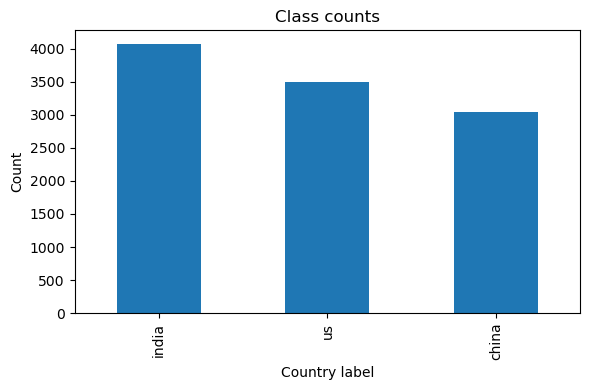

In [5]:
df[label_col].value_counts().plot(kind="bar")
plt.title("Class counts")
plt.xlabel("Country label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The dataset contains three country labels: India, the US, and China. 
The counts are not exactly equal, but they are reasonably close to each other. 
This means the classification task is not heavily imbalanced, although India has slightly more examples than the other two. 
Because the classes are not perfectly balanced, accuracy alone might be misleading, so later I will also look at balanced accuracy and the confusion matrix.

**Let's look at some features:**

In [6]:
feature_cols = [c for c in df.columns if c != label_col]
X = df[feature_cols]
y = df[label_col]

sample_cols = ["ipv4_ttl_0", "tcp_sprt_0", "tcp_dprt_0", "udp_sport_0", "udp_dport_0"]
X[sample_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
ipv4_ttl_0,10625.0,0.074447,0.262509,0.0,0.0,0.0,0.0,1.0
tcp_sprt_0,10625.0,0.042635,0.833667,-1.0,-1.0,0.0,1.0,1.0
tcp_dprt_0,10625.0,-0.023718,0.793660,-1.0,-1.0,0.0,1.0,1.0
udp_sport_0,10625.0,-0.545882,0.711214,-1.0,-1.0,-1.0,0.0,1.0
udp_dport_0,10625.0,-0.560000,0.689994,-1.0,-1.0,-1.0,0.0,1.0


In [7]:
corr_sample_cols = ["ipv4_ttl_0", "tcp_sprt_0", "tcp_dprt_0", "udp_sport_0", "udp_dport_0"]

corr = X[corr_sample_cols].corr()
corr

,ipv4_ttl_0,tcp_sprt_0,tcp_dprt_0,udp_sport_0,udp_dport_0
ipv4_ttl_0,1.000000,-0.351277,-0.341658,0.608415,0.226033
tcp_sprt_0,-0.351277,1.000000,0.496026,-0.798636,-0.797605
tcp_dprt_0,-0.341658,0.496026,1.000000,-0.785507,-0.784493
udp_sport_0,0.608415,-0.798636,-0.785507,1.000000,0.752271
udp_dport_0,0.226033,-0.797605,-0.784493,0.752271,1.000000


In [8]:
ip_cols = ["src_ip", "ipv4_ttl_0", "ipv4_proto_0"]
df[ip_cols].head()

,src_ip,ipv4_ttl_0,ipv4_proto_0
0,10.11.1.3,1,0
1,8.8.8.8,0,0
2,10.11.1.3,1,0
3,10.11.1.3,1,0
4,10.11.1.3,1,0


Most of the columns produced by nprint are binary bit fields representing header values and packet metadata. Because they are one-hot or bit-encoded, they mostly take values of 0 and 1. These features are not intended to be interpreted by eye. Instead, they are designed for models to pick up patterns from combinations of low-level network header bits. For the exploratory section, I only look at a few sample columns to illustrate structure rather than inspecting every feature.

Overall, the dataset has about 10,000 rows and over 1,000 binary and numeric features derived from IPv4, TCP, UDP, and payload bits.  
There are three country labels with reasonably balanced counts.  
There are no missing values, so we can move directly to splitting the data and training baseline models such as Random Forest.


## **Modeling**
**Goal**: We want a classifier that predicts the country label (china, india, us) from the extracted network packet features.

### Train Test Split

We split the dataset into training and test sets, making sure the class proportions are preserved (using stratify).

In [9]:
from sklearn.model_selection import train_test_split

label_col = "label"

# Drop the string IP column and the label column from X
feature_cols = [c for c in df.columns if c not in [label_col, "src_ip"]]

X = df[feature_cols]
y = df[label_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42,
)

X_train.shape, X_test.shape

((7437, 1184), (3188, 1184))

### Fit a baseline model (Random Forest)

The first model is a Random Forest. It is a good baseline because it works well with many features and requires little preprocessing.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.9363237139272271
Balanced accuracy: 0.9331440860819035

Classification report:
              precision    recall  f1-score   support

       china       0.98      0.91      0.94       915
       india       0.92      0.97      0.94      1223
          us       0.92      0.92      0.92      1050

    accuracy                           0.94      3188
   macro avg       0.94      0.93      0.94      3188
weighted avg       0.94      0.94      0.94      3188



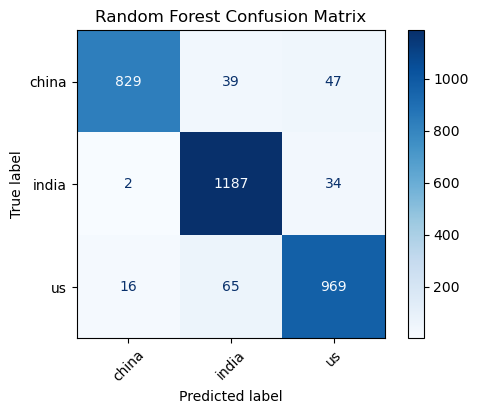

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues", xticks_rotation=45)
plt.title("Random Forest Confusion Matrix")
plt.show()


**Interpretation of Baseline Results:**

The Random Forest baseline performs well. The overall accuracy is a little over **94 percent**, and the balanced accuracy is almost the same, which suggests the model treats the three countries fairly evenly instead of favoring one class. Precision and recall are strong for all three labels, although China has slightly lower recall than India. This just means the model sometimes mis-labels China packets as India or the US.

The confusion matrix helps confirm this pattern. Most predictions fall along the diagonal, meaning the model usually predicts the correct country. The largest block is India, which the model gets right most often. China shows more off-diagonal values, which lines up with the weaker recall in the classification report. However, the number of mistakes is still relatively small, and the errors are spread across countries rather than concentrated in one direction.

Taken together, these results show that a straightforward Random Forest already provides a strong baseline.

**Let's do a quick Cross-validation:**

In [12]:
from sklearn.model_selection import cross_val_score

rf_cv = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
)

# Evaluate using 5-fold CV on the *training* set
cv_scores = cross_val_score(
    rf_cv,
    X_train,
    y_train,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1
)

print("Cross-validation balanced accuracies:", cv_scores)
print("Mean CV balanced accuracy:", cv_scores.mean())
print("Std across folds:", cv_scores.std())


Cross-validation balanced accuracies: [0.92871758 0.92904188 0.9262927  0.94097441 0.92303554]
Mean CV balanced accuracy: 0.9296124218011148
Std across folds: 0.006074488065867316


**Cross-Validation Interpretation:** The Random Forest model was evaluated with 5-fold cross-validation using balanced accuracy. The individual fold scores ranged from approximately 0.92 to 0.94, with a mean close to 0.93 and a small standard deviation. This indicates that **performance is consistent across different train–test splits and that the model is not depending on a single favorable partition of the data**. The relatively low variation across folds suggests the baseline model is stable and generalizes well on this dataset.

**Feature Importance:**

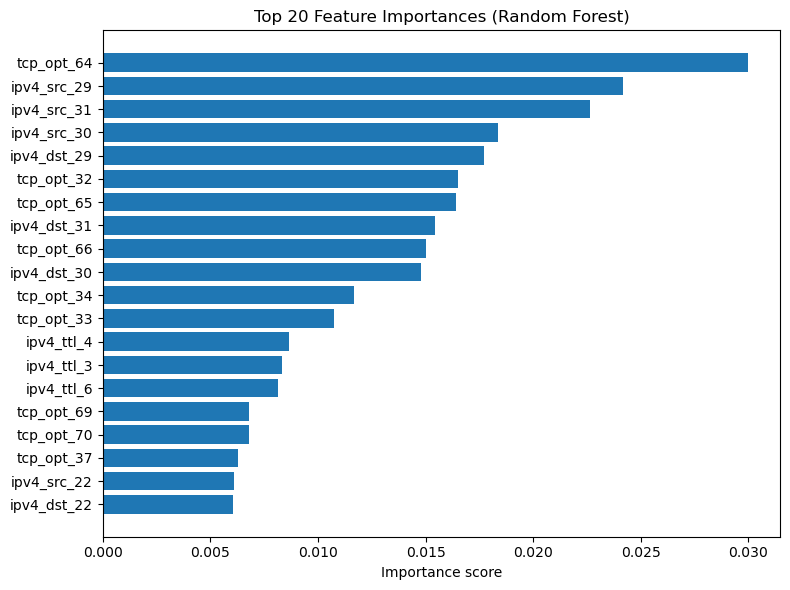

In [13]:
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

# We will display the top 20 only
top_k = 20
top_features = X.columns[indices][:top_k]
top_importances = importances[indices][:top_k]

plt.figure(figsize=(8,6))
plt.barh(top_features[::-1], top_importances[::-1])
plt.xlabel("Importance score")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


**Interpreting feature importance:**

Most of the top ranked features come from individual IPv4 and TCP header bits rather than payload bytes. These values correspond to low–level protocol fields such as options, source addresses, or TTL bits that reflect different OS network stacks, routing paths, or middleboxes associated with traffic coming from each region. Rather than being meaningful on their own, these bits form patterns that the Random Forest can learn. The main takeaway is simply that the model is relying on packet header structure to separate the countries.

### **Other Models**

The random forest model gave stable results across folds. With this baseline established, I now compare several standard classifiers under the same training setup. The goal is not to tune models deeply, but rather to see **whether the observed performance is model-specific or represents a general pattern across different supervised learning methods**.

To compare different classifiers under the same split, I define a small helper function that fits a model, evaluates it on the test set, and stores accuracy and balanced accuracy.


In [14]:
import warnings
from sklearn.exceptions import ConvergenceWarning


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

results = {}

def evaluate_model(name, model):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    
    results[name] = {
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
    }
    
    print(f"{name}")
    print(f"  Accuracy:          {acc:.4f}")
    print(f"  Balanced accuracy: {bal_acc:.4f}")
    print()

**Define the models**: I will try out Logistic Regression, Linear SVM, RBF SVM, Gradient Boosting, and KNN (k = 5). 

In [15]:
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
    ),
    
    "Logistic Regression": make_pipeline(
        StandardScaler(with_mean=False),
        LogisticRegression(
            max_iter=1000,
            multi_class="multinomial",
        )
    ),
    
    "Linear SVM": make_pipeline(
        StandardScaler(with_mean=False),
        LinearSVC(
            random_state=42,
        )
    ),
    
    "RBF SVM": make_pipeline(
        StandardScaler(with_mean=False),
        SVC(
            kernel="rbf",
            C=1.0,
            gamma="scale",
            random_state=42,
        )
    ),
    
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42,
    ),
    
    "KNN (k=5)": make_pipeline(
        StandardScaler(with_mean=False),
        KNeighborsClassifier(
            n_neighbors=5,
        )
    ),
}

In [16]:
# Run the models. This might take a while to run. 

for name, model in models.items():
    evaluate_model(name, model)


Random Forest
  Accuracy:          0.9363
  Balanced accuracy: 0.9331



/Users/chrislowzx/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression
  Accuracy:          0.9178
  Balanced accuracy: 0.9168

Linear SVM
  Accuracy:          0.9228
  Balanced accuracy: 0.9219

RBF SVM
  Accuracy:          0.3836
  Balanced accuracy: 0.3334

Gradient Boosting
  Accuracy:          0.9294
  Balanced accuracy: 0.9269

KNN (k=5)
  Accuracy:          0.8184
  Balanced accuracy: 0.8176



**Comparison Interpretation:** 

Across different model families, **Random Forest and Gradient Boosting achieved the highest and most stable performance.** Linear models such as Logistic Regression and Linear SVM performed reasonably well given the very high-dimensional binary feature space. In contrast, the non-linear RBF SVM struggled, which is expected because RBF kernels do not scale well to thousands of sparse binary features and often fail to find a meaningful boundary in these settings. Overall, the tree-based approaches remain the strongest models for this type of network traffic representation.


### **AutoGluon**

As a final experiment, I trained AutoGluon’s `TabularPredictor` on the same packet-level feature table. I used the `medium_quality_faster_train` preset with a 5-minute time limit, although training finished in only a few seconds on my machine.

Because I did not install optional backends such as **PyTorch**, **LightGBM**, **CatBoost**, or **XGBoost**, AutoGluon automatically skipped all neural-network and gradient-boosting models. The resulting search focused entirely on tree-based models (Random Forest and Extra Trees) and then constructed a second-level weighted ensemble over the best four. AutoGluon’s internal validation reported about 95 percent accuracy, but when evaluated on a separate held-out test set the final accuracy was around 94 percent (balanced accuracy 0.94). This is slightly above the manually tuned Random Forest baseline (about **93.6 percent accuracy**, **93.3 percent balanced accuracy**) used earlier in the notebook.

When evaluated on the held-out test set, the AutoGluon ensemble again achieved very strong performance (around **94 percent balanced accuracy**) using only the tree models. This suggests that automated ensembling can extract a bit more signal from the same features even without the full set of AutoGluon backends. The remaining gap relative to the leaderboard entry (approximately **96.8 percent balanced accuracy** with a full AutoGluon installation) appears to come from additional model families such as modern gradient boosting and neural networks, which were skipped in this environment.

Overall, these results indicate that the header-level representation already contains enough structure for strong classification performance.


*Note: Due to not installing other optional backends, it is normal that you see some warning messages when you run the code.*

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

X = df.drop(columns=["label"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

train_data_ag = X_train.copy()
train_data_ag["label"] = y_train

from autogluon.tabular import TabularPredictor

predictor = TabularPredictor(
    label="label",
    problem_type="multiclass",
    verbosity=0,
)

_ = predictor.fit(
    train_data=train_data_ag,
    time_limit=300,
    presets="medium_quality_faster_train",
    verbosity=0,
)

y_pred_test = predictor.predict(X_test)

print("AutoGluon test accuracy:         ",
      accuracy_score(y_test, y_pred_test))
print("AutoGluon test balanced accuracy:",
      balanced_accuracy_score(y_test, y_pred_test))


	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch installed by running `pip install -U torch`
	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch installed by running `pip install -U torch`
		Import fastai failed. A quick tip is to install via `pip install autogluon.tabular[fastai]==1.4.1b20251206`. 
	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch installed by running `pip install -U torch`
		`import lightgbm` failed. A quick tip is to install via `pip install autogluon.tabular[lightgbm]==1.4.1b20251206`.
	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch installed by running `pip install -U torch`
		`import lightgbm` failed. A quick tip is to install via `pip install autogluon.tabular[lightgbm]==1.4.1b20251206`.
	Failed to import torch or check CUDA availability!Please 

AutoGluon test accuracy:          0.9425972396486826
AutoGluon test balanced accuracy: 0.9395420627580192


In [18]:
# AutoGluon leaderboard for all trained models: this is their internal comparison table, not the final report. 
# The final scores are above, with a balanced accuracy of 0.9395420627580192. 
leaderboard = predictor.leaderboard(df, silent=True)
leaderboard

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestEntr,0.979671,0.943548,accuracy,0.105368,0.027311,0.516439,0.105368,0.027311,0.516439,1,True,2
1,WeightedEnsemble_L2,0.979200,0.948925,accuracy,0.208170,0.054992,1.026258,0.006709,0.000226,0.006757,2,True,5
2,RandomForestGini,0.979012,0.944892,accuracy,0.097062,0.027107,0.529388,0.097062,0.027107,0.529388,1,True,1
3,ExtraTreesEntr,0.977506,0.946237,accuracy,0.104399,0.027659,0.490113,0.104399,0.027659,0.490113,1,True,4
4,ExtraTreesGini,0.976941,0.940860,accuracy,0.115028,0.025521,0.480687,0.115028,0.025521,0.480687,1,True,3


## **Conclusion**

In this notebook I trained a set of baseline models on the packet-level features generated from the dataset. **A Random Forest achieved the strongest performance among the manually selected models, reaching about 94 percent accuracy with balanced results across all three classes.** Cross-validation confirmed that this performance is stable across different train-test splits. Simpler linear models (Logistic Regression) and Gradient Boosting also performed well, while models that rely on strong assumptions about the feature space, such as the RBF SVM, struggled with the high-dimensional sparse representation.

An additional experiment using AutoGluon showed that an automated ensemble of tree-based methods can push the accuracy slightly higher on the same features, without any manual tuning. Overall, the results indicate that header-level structure alone contains enough signal to distinguish traffic from the United States, China, and India. More advanced modeling or richer payload features could be explored in future work, but for the purpose of a baseline reproduction this level of performance already compares favorably with the published results.

## **Appendix A. Offline Processing Files**

This folder contains the scripts and intermediate files used to convert the original PCAPNG capture and extract features and labels:

* `traffic.pcapng` — original downloaded capture
* `traffic_fixed.pcap` — converted capture used by nPrint
* `fix_pcap_safe.py` — script used to convert timestamps
* `traffic_features.csv` — nPrint output
* `labels_extracted.csv` — labels extracted with Tshark
* `extract_labels_tshark.py` — script for extracting labels from packet comments

These steps were done outside the notebook. The final dataset used for training is `final_dataset_with_labels.csv`.

Appendix B and C show more of the data processing steps. 

## **Appendix B. Data Preprocessing (done offline)**

The packet capture I downloaded was in the PcapNG format, which turned out to be incompatible with the older version of the nPrint tool that I needed for feature extraction. To work around this, I converted the original file into a regular `.pcap` file using Scapy. That conversion mainly rewrites timestamps into a format the older tools can read. 


(Note: this part is a bit tricky. I used Gemini 3.0 Pro to assist with installing Conda (my Mac isn’t compatible with some nPrint dependencies) as well as converting traffic data from `.pcapng` to `.pcap`. The conversion script (`fix_pcap_safe.py`) and the previously downloaded files are located in `course-project-chrislowzhengxi/final/offline_processing`.)


After that, I used the `nprint` command-line tool (outside of this notebook) to extract network-level features. The tool parses each packet of the PCAP file and produces a feature table in CSV form. This CSV is what the rest of the notebook loads and analyzes. I generated it once and added it directly to the project folder so the notebook does not depend on installing nPrint or running the extraction again.

The command I used was essentially:

```bash
nprint -P traffic_fixed.pcap -W traffic_features.csv -4 -t -u -p 20
```

The main flags tell nPrint to include IPv4, TCP, and UDP header information, and to grab a small part of the payload. The resulting file (`traffic_features.csv`) contains the full set of features and will be used for model training and evaluation below.

## **Appendix C. Adding Labels to the Feature Data (done offline)**

After running `nprint`, I ended up with a CSV containing only packet-level features. It did not include the country label. The reason is that the label was stored inside the original PcapNG file as a packet comment rather than a normal field, so `nprint` never saw it.

To move forward with supervised learning, I needed a label column. I extracted the labels from the PcapNG file using `tshark`, then merged those labels with the feature rows.

### Step 1. Extract labels using Tshark

Each packet in the original `traffic.pcapng` included a comment such as `13682128230572000042,china`. That comment contains both an ID and the country. Using Tshark, I pulled out the `ip.src` field and the per-packet comment:

```python
# offline_processing/extract_labels_tshark.py

command = [
    "tshark", "-n", "-r", pcap_file,
    "-Y", "ip",
    "-T", "fields",
    "-e", "ip.src",
    "-e", "frame.comment",
    "-E", "separator=,",
    "-E", "quote=d"
]
```

This produced a small CSV with the source IP and the raw comment label.

(Note: Again, this part is tricky, so I asked Gemini for help. The prompt can be seen at the top of `offline_processing/extract_labels_tshark.py`.)

### Step 2. Merge with feature table

The next step was to join the extracted labels with the feature rows. Since both files contained the exact same number of rows and appeared in the same order, I merged them by index.

I also cleaned the label string so it only keeps the country part.

This step was performed during preprocessing, so it does **not** appear in this notebook. The output of that step is the file `final_dataset_with_labels.csv`, which is the dataset used for training. It is generated from the original `traffic.pcapng` file and includes the extracted country labels. Below is the script: 


```python
import pandas as pd

features_df = pd.read_csv('traffic_features.csv')
labels_df = pd.read_csv('labels_extracted.csv')

# Clean the Label Column (from "13682128230572000042,china" to "china")
def parse_label(val):
    if isinstance(val, str) and ',' in val:
        return val.split(',')[-1].strip() # Take the last part (the text label)
    return 'Unknown'

labels_df['clean_label'] = labels_df['raw_label'].apply(parse_label)

# Assign the label to the feature set
features_df['label'] = labels_df['clean_label']

features_df.to_csv('final_dataset_with_labels.csv', index=False)
```

### Result

The final dataset now includes a `label` column at the end. This is the version used for all modeling. In the rest of the notebook, I simply load the combined CSV and treat `label` as the target.

That’s all that’s needed to start training models.
